In [1]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import pandas as pd

/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load the Best Probe Weights

In [30]:
# Path to your results
# MODEL_NAME = "Qwen/Qwen2.5-Math-7B-Instruct"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
MODEL_ALIAS = MODEL_NAME.split("/")[-1]
RESULTS_DIR = f"../probe_results/DATA/SR_DATA/MATH/{MODEL_ALIAS}_maxlen_3000_k_1_temp_0.0"

# Load best probe data
with open(f"{RESULTS_DIR}/best_probe_predictions.json", 'r') as f:
    best_probe = json.load(f)

probe_weights = np.array(best_probe['probe_weights'])  # [D] dimension vector
best_layer = best_probe['best_layer']
best_position = best_probe['best_position']
cv_score = best_probe['cv_score']
test_score = best_probe['test_score']

print(f"Best probe: Layer {best_layer}, Position {best_position}")
print(f"CV Score: {cv_score:.4f}, Test Score: {test_score:.4f}")
print(f"Probe weights shape: {probe_weights.shape}")

Best probe: Layer 18, Position -1
CV Score: 0.8803, Test Score: 0.8595
Probe weights shape: (2560,)


## 2. Load Model and Extract Embedding Matrix

In [31]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
vocab_size = len(tokenizer)
print(f"Vocabulary size: {vocab_size}")

# Load model to get embeddings
print("Loading model (this may take a moment)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="cpu",  # Keep on CPU for analysis
)

# Get embedding matrix
embedding_matrix = model.get_input_embeddings().weight.data.cpu().float().numpy()  # [vocab_size, d_model]
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Vocabulary size: 151669
Loading model (this may take a moment)...


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]



Embedding matrix shape: (151936, 2560)


## 3. Compute Dot Products with All Tokens

In [32]:
# Compute dot product: embedding_matrix @ probe_weights
# This tells us how much each token "activates" the probe direction
dot_products = embedding_matrix @ probe_weights  # [vocab_size]

print(f"Dot products shape: {dot_products.shape}")
print(f"Min: {dot_products.min():.4f}, Max: {dot_products.max():.4f}, Mean: {dot_products.mean():.4f}")

Dot products shape: (151936,)
Min: -1.7368, Max: 1.8767, Mean: 0.1594


## 4. Find Top Tokens (Highest Activations)

In [33]:
# Get top K tokens with highest dot products
TOP_K = 50

top_indices = np.argsort(dot_products)[-TOP_K:][::-1]  # Descending order
top_scores = dot_products[top_indices]
top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

# Create DataFrame
top_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': top_indices,
    'token': top_tokens,
    'dot_product': top_scores,
})

print(f"\n{'='*60}")
print(f"TOP {TOP_K} TOKENS (Highest Activation)")
print(f"{'='*60}\n")
print(top_df.to_string(index=False))


TOP 50 TOKENS (Highest Activation)

 rank  token_id            token  dot_product
    1    142855         совершен     1.876673
    2     57034           joking     1.845227
    3    121508                漪     1.844163
    4     93372         UserType     1.838755
    5    114307              俗话说     1.803048
    6     16087          opposed     1.769826
    7    110991              面对面     1.741789
    8    134456               Ча     1.690728
    9     90494            smack     1.683254
   10    110744             希望能够     1.676994
   11     43137            izzle     1.676368
   12     62829          consort     1.671351
   13      6670             orge     1.644816
   14     97366            utely     1.643417
   15     91197      setPosition     1.636999
   16     70362         extrapol     1.633932
   17     75055             Thur     1.616183
   18     61010 ExceptionHandler     1.600682
   19    121715                磬     1.596922
   20     78119         Colleges     1.5961

## 5. Find Bottom Tokens (Lowest Activations)

In [34]:
# Get bottom K tokens (most negative)
bottom_indices = np.argsort(dot_products)[:TOP_K]
bottom_scores = dot_products[bottom_indices]
bottom_tokens = [tokenizer.decode([idx]) for idx in bottom_indices]

bottom_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': bottom_indices,
    'token': bottom_tokens,
    'dot_product': bottom_scores,
})

print(f"\n{'='*60}")
print(f"BOTTOM {TOP_K} TOKENS (Lowest Activation)")
print(f"{'='*60}\n")
print(bottom_df.to_string(index=False))


BOTTOM 50 TOKENS (Lowest Activation)

 rank  token_id     token  dot_product
    1     20125    andles    -1.736779
    2     26480       -lo    -1.460091
    3     52265   .Accept    -1.429870
    4    111318        租车    -1.429633
    5     11144      appy    -1.412855
    6     23518    arness    -1.411349
    7    105758        而来    -1.402674
    8     14050       lux    -1.392638
    9    140517      займ    -1.369815
   10      1199       its    -1.339931
   11     73650       (lo    -1.337933
   12     78933    _Parms    -1.327429
   13       775        lo    -1.322994
   14     87090    :start    -1.316824
   15     61790     ---</    -1.308614
   16     42221      -cut    -1.299828
   17     43924       Lay    -1.299392
   18      9369       Mex    -1.281934
   19    124214        بل    -1.278276
   20    117233        索取    -1.277018
   21     13912     codes    -1.268173
   22     99580         显    -1.264361
   23     18597     Begin    -1.261474
   24     36949       mex

## 6. Visualize Distribution

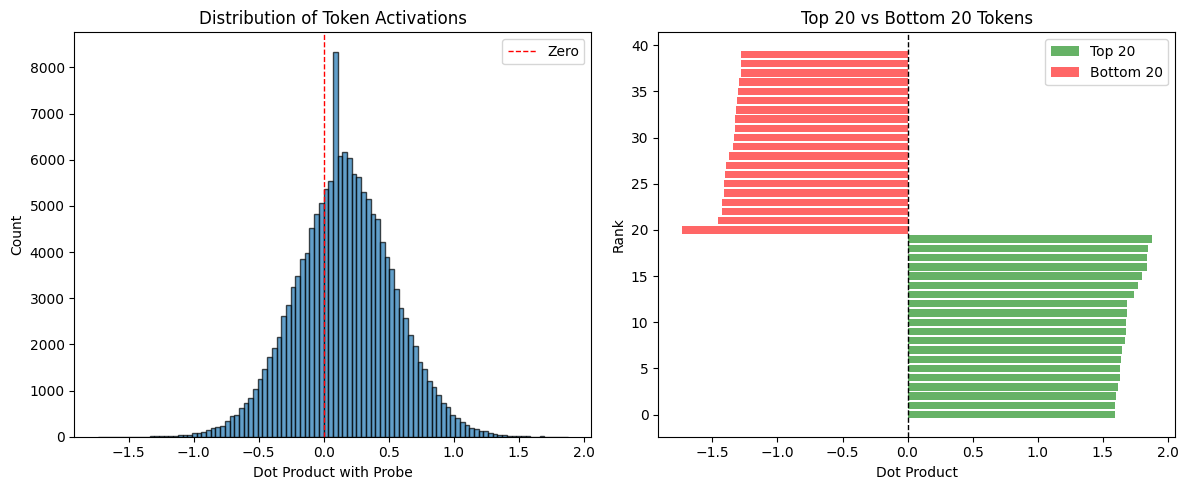

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(dot_products, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Dot Product with Probe')
plt.ylabel('Count')
plt.title('Distribution of Token Activations')
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.legend()

# Top/Bottom bars
plt.subplot(1, 2, 2)
plt.barh(range(20), top_scores[:20][::-1], color='green', alpha=0.6, label='Top 20')
plt.barh(range(20, 40), bottom_scores[:20], color='red', alpha=0.6, label='Bottom 20')
plt.xlabel('Dot Product')
plt.ylabel('Rank')
plt.title('Top 20 vs Bottom 20 Tokens')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend()

plt.tight_layout()
plt.show()

## 7. Save Results

In [36]:
# Save to CSV
top_df.to_csv(f"{RESULTS_DIR}/top_tokens.csv", index=False)
bottom_df.to_csv(f"{RESULTS_DIR}/bottom_tokens.csv", index=False)

print(f"\nResults saved to:")
print(f"  - {RESULTS_DIR}/top_tokens.csv")
print(f"  - {RESULTS_DIR}/bottom_tokens.csv")


Results saved to:
  - ../probe_results/DATA/SR_DATA/MATH/Qwen3-4B-Instruct-2507_maxlen_3000_k_1_temp_0.0/top_tokens.csv
  - ../probe_results/DATA/SR_DATA/MATH/Qwen3-4B-Instruct-2507_maxlen_3000_k_1_temp_0.0/bottom_tokens.csv


## 8. Interpretation

- **High dot product tokens**: These tokens, when they appear at the probe's position/layer, strongly activate in the direction the probe learned to associate with high success rate.
- **Low dot product tokens**: These tokens activate in the opposite direction

**Note**: This analysis uses the embedding matrix, so it shows tokens at the input level. The actual activations the probe sees are after being processed through layers of the transformer, so this is an approximation of what the probe detects.